# Circuit learning module: Pennylane with SPSA

This code is inspired by [Quanthoven](https://github.com/CQCL/Quanthoven/blob/main/experiment.ipynb) and [Pennylane demo](https://pennylane.ai/qml/demos/spsa.html).

In [9]:
import json
import os
import sys
import glob
import collections
from pathlib import Path
import numpy as np
import pennylane as qml
from sympy import default_sort_key
from discopy.quantum.pennylane import to_pennylane, PennyLaneCircuit
from noisyopt import minimizeSPSA
from scipy.optimize import minimize
from utils import transform_into_pennylane_circuits, read_diagrams, get_symbols, create_labeled_training_classes, create_labeled_test_validation_classes, acc_from_dict, loss_from_dict, create_labeled_training_classes_new

this_folder = os.path.abspath(os.getcwd()) + "/data"

In [10]:
def genbin(n, bs=''):
    if len(bs) == n:
        return bs
    else:
        return np.array([genbin(n, bs + '0'), genbin(n, bs + '1')]).flatten()

## Read circuit data

We read the circuits from the pickled files.

In [11]:
workload = "execution_time"

classification = 2  # 1 = binary classification
layers = 1
#n_wire_count = 1
main_path = this_folder + "/" + workload

In [12]:
circuit_training = main_path + "/circuits/" + "training"
circuit_validation = main_path + "/circuits/" +  "validation"
circuit_test = main_path + "/circuits/" + "/test"

In [13]:
#training_circuits_paths = glob.glob(circuit_training + "/*.p")
validation_circuits_paths = glob.glob(circuit_validation + "/*.p")
test_circuits_paths = glob.glob(circuit_test + "/*.p")

#training_circuits_paths = glob.glob(circuit_training + "/q_[0-2][0-9].p")

#training_circuits_paths = glob.glob(circuit_training + "/q_[0-7].p")
#validation_circuits_paths = glob.glob(circuit_validation + "/q_[0-9].p")
#test_circuits_paths = glob.glob(circuit_test + "/q_[0-9].p")

In [14]:
# 2 classes cherry pick
#training_circuits_paths = ['/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_0.p',
#  '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_1.p',
#  '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_2.p',
#  '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_3.p',
#  '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_4.p',
#  '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_9.p',
#  '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_35.p',
#  '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_183.p',
#  '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_205.p',
# '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_290.p']

In [15]:
# 4 classes cherry pick
training_circuits_paths = ['/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_52.p',
 '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_116.p',
 '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_26.p',
 '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_185.p',
 '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_221.p',
 '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_55.p',
 '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_105.p',
 '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_198.p',
 '/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_35.p',
'/home/farida/Documents/SQL2Circuits_Farida/data/execution_time/circuits/training/q_167.p']

In [16]:
# # Initialize an empty list to store matching keys
# #matching_keys = []
# c = 0

# # Iterate through the dictionary items
# for key, value in training_data_labels[0].items():
#     if value == [0, 0, 0, 1]:
#         #matching_keys.append(key)
#         print(key)
#         c = c+1
#     if c>3:
#         break

In [17]:
training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

In [18]:
#training_circuits.keys()

## Read training and test data

In [19]:
training_data, test_data, validation_data = None, None, None
data_path = this_folder + "/" + workload + "/"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

#training_data_labels = create_labeled_training_classes(training_data, classification, workload)
training_data_labels = create_labeled_training_classes_new(training_data, classification)
test_data_labels = create_labeled_test_validation_classes(test_data, training_data_labels[1], workload)
validation_data_labels = create_labeled_test_validation_classes(validation_data, training_data_labels[1], workload)

In [20]:
# remove the circuits for which there are no labels

training_circuits = {file_name: circuit for file_name, circuit in training_circuits.items() if file_name in training_data_labels[0]}
validation_circuits = {file_name: circuit for file_name, circuit in validation_circuits.items() if file_name in validation_data_labels}
test_circuits = {file_name: circuit for file_name, circuit in test_circuits.items() if file_name in test_data_labels}


In [21]:
#training_data_labels[0]

## Constructing Pennylane circuits

In [22]:
qml_training_circuits, train_symbols = transform_into_pennylane_circuits(training_circuits)
qml_test_circuits, test_symbols = transform_into_pennylane_circuits(test_circuits)
qml_validation_circuits, val_symbols = transform_into_pennylane_circuits(validation_circuits)

In [23]:
print("Number of training circuits: ", len(qml_training_circuits))
print("Number of validation circuits: ", len(qml_validation_circuits))
print("Number of test circuits: ", len(qml_test_circuits))

print("# of params: ", len(train_symbols))

Number of training circuits:  10
Number of validation circuits:  49
Number of test circuits:  47
# of params:  35


## Post-selection

In [24]:
def post_selection(circuit_samples, n_qubits, post_selection):
    selected_samples = []
    post_select_array = np.array([0]*(n_qubits - post_selection))
    selected_samples = circuit_samples[np.all(circuit_samples[:, post_selection - 1 :-1] == post_select_array, axis = 1)]
    return selected_samples[:, :post_selection].tolist()

## Cost and prediction functions

Because Pennylane does not implement post-selection, we need to implement it as we would implement it on a real quantum hardware i.e. using sampling.

In [25]:
def make_pred_fn(circuits):
    
    def predict(params):
        predictions = {}
        for c in circuits:
            post_selected_samples = []
            n_qubits = circuits[c]["n_qubits"]
            circuit_elements = circuits[c]["circuit_elements"]
            symbol_to_index = circuits[c]["symbol_to_index"]
            def qml_circuit(circ_params):
                    for op, param, wires in circuit_elements:
                        if len(param) > 0:
                            param = param[0]
                            op(circ_params[symbol_to_index[param]], wires = wires)
                        else:
                            op(wires = wires)
                    return qml.sample()
            dev = qml.device("qiskit.aer", wires=n_qubits)
            circuit = qml.QNode(qml_circuit, dev)
            measurement = circuit(params)
            post_selected_samples = post_selection(measurement, n_qubits, classification)
            post_selected_samples = [tuple(map(int, t)) for t in post_selected_samples]
            counts = collections.Counter(post_selected_samples)
            if len(post_selected_samples) == 0:
                predictions[c] = [1] + [1e-9]*(2**classification - 1)
                continue
            try:
                predicted = counts.most_common(1)[0][0]
                binary_string = ''.join(str(bit) for bit in predicted[::-1])
                binary_int = int(binary_string, 2)
                result = [1e-9]*2**classification
                result[binary_int] = 1
                predictions[c] = result
            except:
                predictions[c] =[1] + [1e-9]*(2**classification - 1)
        return predictions
            
    return predict

In [26]:
def cross_entropy(predictions, targets):
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

In [27]:
def make_cost_fn(pred_fn, labels):
    
    def cost_spsa(params, **kwargs):

        #print("params", params)
        predictions = pred_fn(params)
        #print("predictions ", predictions)
        
        cost = loss_from_dict(predictions, labels) #-np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        #cost = cross_entropy(np.array(predictions), np.array(labels))
        costs.append(cost)

        accuracy = acc_from_dict(predictions, labels) #np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(accuracy)
        
        return cost
    
    costs, accuracies = [], []
    return cost_spsa, costs, accuracies

## SPSA minimization

In [42]:
EPOCHS = 100
SEED = 1234
result_file = workload + "_pennylane_" + str(classification) + "_" + str(layers)

#np.random.seed(SEED)
rng = np.random.default_rng(SEED)
init_params_spsa = np.array(rng.random(len(train_symbols)))
#init_params_spsa = torch.tensor(init_params_spsa)

train_pred_func = make_pred_fn(qml_training_circuits)
dev_pred_func = make_pred_fn(qml_validation_circuits)
test_pred_func = make_pred_fn(qml_test_circuits)

train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_func, training_data_labels[0])
dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_func, validation_data_labels)
test_cost_fn, test_costs, test_accs = make_cost_fn(test_pred_func, test_data_labels)

In [43]:
len(train_symbols)

35

In [44]:
def callback_fn(xk):
    valid_loss = dev_cost_fn(xk)
    train_loss = np.around(min(float(train_costs[-1]), float(train_costs[-2])), 4)
    train_acc = np.around(min(float(train_accs[-1]), float(train_accs[-2])), 4)
    valid_acc = np.around(float(dev_accs[-1]), 4)
    iters = int(len(train_accs)/2)
    #if iters % 200 == 0:
    info = f"Epoch: {iters}   "\
            + f"train/loss: {train_loss}   "\
            + f"valid/loss: {np.around(float(valid_loss), 4)}   "\
            + f"train/acc: {train_acc}   "\
            + f"valid/acc: {valid_acc}"

    with open(this_folder+"/results/" + result_file + ".txt", "a") as f:
        f.write(info + "\n")

    print(info, file=sys.stderr)
    
    return valid_loss

In [45]:
#train_cost_fn(init_params_spsa)

In [46]:
training_data_labels[0]["q_2"]

[1, 0, 0, 0]

In [47]:
with open(this_folder+"/results/" + result_file + ".txt", "w") as f:
        pass

result = minimizeSPSA(train_cost_fn, 
                      x0 = init_params_spsa, 
                      a = 1, 
                      c = 1, 
                      niter=EPOCHS,
                      paired = False,
                      callback=callback_fn)

#print(test_cost_fn(result))

Epoch: 1   train/loss: 46.6273   valid/loss: 31.0849   train/acc: 0.0   valid/acc: 0.8776
Epoch: 2   train/loss: 41.4465   valid/loss: 31.0849   train/acc: 0.0   valid/acc: 0.8776
Epoch: 3   train/loss: 36.2657   valid/loss: 56.989   train/acc: 0.1   valid/acc: 0.7755
Epoch: 4   train/loss: 46.6273   valid/loss: 41.4465   train/acc: 0.1   valid/acc: 0.8367
Epoch: 5   train/loss: 41.4465   valid/loss: 46.6273   train/acc: 0.2   valid/acc: 0.8163
Epoch: 6   train/loss: 36.2657   valid/loss: 51.8082   train/acc: 0.1   valid/acc: 0.7959
Epoch: 7   train/loss: 41.4465   valid/loss: 46.6273   train/acc: 0.1   valid/acc: 0.8163
Epoch: 8   train/loss: 41.4465   valid/loss: 62.1698   train/acc: 0.1   valid/acc: 0.7551
Epoch: 9   train/loss: 36.2657   valid/loss: 36.2657   train/acc: 0.1   valid/acc: 0.8571
Epoch: 10   train/loss: 36.2657   valid/loss: 36.2657   train/acc: 0.2   valid/acc: 0.8571
Epoch: 11   train/loss: 31.0849   valid/loss: 46.6273   train/acc: 0.3   valid/acc: 0.8163
Epoch: 12

In [34]:
#print(result["x"])

In [35]:
# print(len(init_params_spsa))
# print(len(pretrained_init_params))

In [36]:
# pretrained_init_params = np.array([2.2883275e+00,  1.4787253e+01 , 1.2467823e+00 ,-2.4412410e+00,
#   1.1103818e+01 ,-4.5024571e+00, -9.8447123e+00, -1.2420528e+00,
#   1.6240840e+00, -1.0575137e+01, -2.0133312e+00, -3.3028386e+00,
#  -5.4381108e+00,  2.7624948e+00,  7.5291724e+00,  9.1494665e+00,
#   5.6830378e+00,  1.1192737e+01,  1.1058793e+01,  1.2830998e+01,
#  -6.9563800e-01,  1.3418126e+01, -4.4506378e+00, -1.2585538e+01,
#   8.6699331e-01 ,-6.5698805e+00,  6.2438321e+00,  5.3598537e+00,
#   1.1940898e+01 ,-1.9150276e+00, -2.5869671e-01,  6.9462986e+00,
#  -1.2667023e-02 ,-2.4349129e+00,  6.2545209e+00,  1.4662850e+01,
#   1.6996973e+00 ,-1.0904786e+01, -8.2938862e+00,  5.1593623e+00,
#   9.6029081e+00, 0.8326782 , 0.7002651 , 0.31236664])

# with open(this_folder+"/results/" + result_file + ".txt", "w") as f:
#         pass

# result = minimizeSPSA(train_cost_fn, 
#                       x0 = pretrained_init_params, 
#                       a = 0.1, 
#                       c = 0.1, 
#                       niter=EPOCHS,
#                       paired = False,
#                       callback=callback_fn)

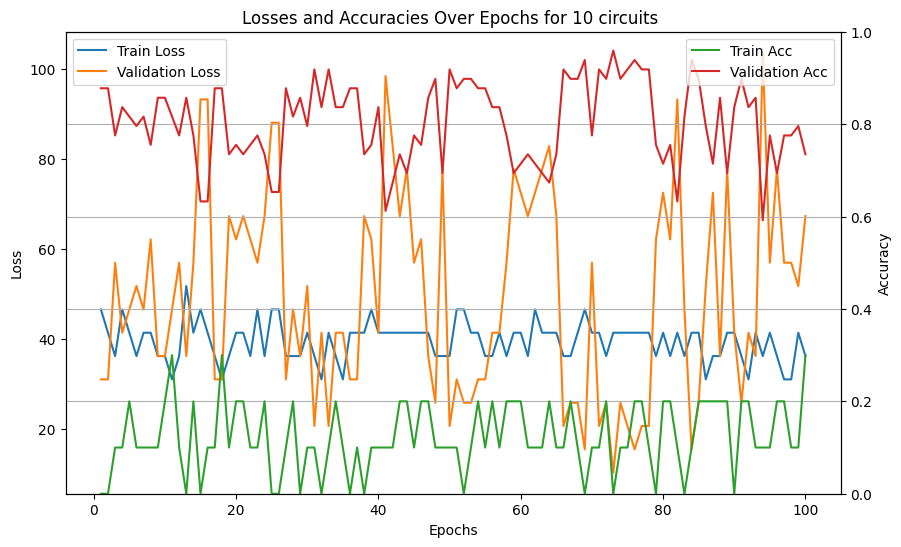

In [48]:
with open(this_folder+"/results/" + result_file + ".txt", "r") as f:
    lines = f.readlines()

epochs = []
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for line in lines:
    # Parse the line and extract relevant information
    if "Epoch:" in line:
        parts = line.split()
        epochs.append(int(parts[1]))
        train_loss = float(parts[3])
        valid_loss = float(parts[5])
        train_acc = float(parts[7])
        valid_acc = float(parts[9])
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_acc)
        valid_accuracies.append(valid_acc)

import matplotlib.pyplot as plt

# Assume you already have the parsed data in the following lists:
# epochs, train_losses, valid_losses, train_accuracies, valid_accuracies

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the losses on the first y-axis
ax1.plot(epochs, train_losses, label='Train Loss', color='tab:blue')
ax1.plot(epochs, valid_losses, label='Validation Loss', color='tab:orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='black')
ax1.legend(loc='upper left')
# Set the axis limits using ax
#ax1.set_xlim(0, 500)   # Set the x-axis limits from 0 to 500
#ax1.set_ylim(0, 80)  # Set the y-axis limits from 0 to 80


# Create a second y-axis
ax2 = ax1.twinx()

# Plot the accuracies on the second y-axis
ax2.plot(epochs, train_accuracies, label='Train Acc', color='tab:green')
ax2.plot(epochs, valid_accuracies, label='Validation Acc', color='tab:red')
ax2.set_ylabel('Accuracy', color='black')
ax2.legend(loc='upper right')

# Set the axis limits using ax
#ax2.set_xlim(0, 500)   # Set the x-axis limits from 0 to 500
ax2.set_ylim(0, 1)  # Set the y-axis limits from 0 to 25


plt.title('Losses and Accuracies Over Epochs for ' + str(len(qml_training_circuits)) + " circuits ")
plt.grid(True)
plt.show()


# Calculate confusion matrix using test set

In [49]:
test_data_predictions = test_pred_func(result["x"])

In [50]:
actual_test_labels = np.zeros(len(test_data_predictions))
predicted_test_labels = np.zeros(len(test_data_predictions))

j=0

for key in test_data_predictions:
    for i in range(4):
        if test_data_predictions[key][i]==1:
            predicted_test_labels[j] = i

        if test_data_labels[key][i]==1:
            actual_test_labels[j] = i

    j=j+1

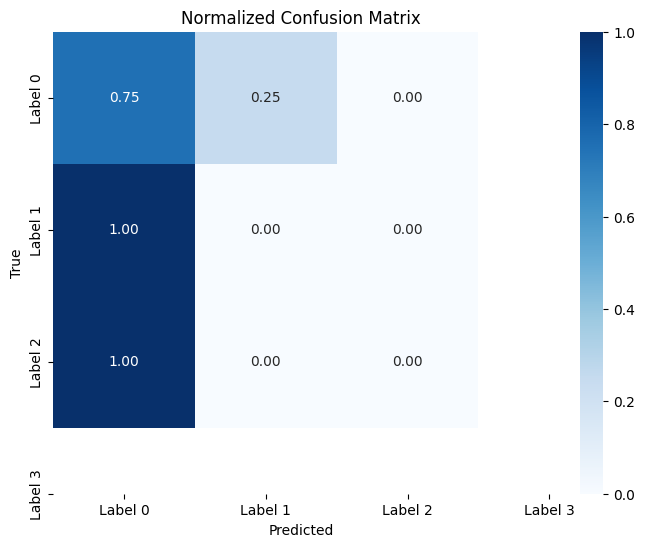

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Calculate the confusion matrix (normalized)
cm = confusion_matrix(actual_test_labels, predicted_test_labels, normalize='true')

# Create a colorful heatmap plot
plt.figure(figsize=(8, 6))
#sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f", xticklabels=['Label 0', 'Label 1'], yticklabels=['Label 0', 'Label 1'])
sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f", xticklabels=['Label 0', 'Label 1', 'Label 2', 'Label 3'], yticklabels=['Label 0', 'Label 1', 'Label 2', 'Label 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()